The objective of this notebook is to assess the qaulity of the optical flow algorithm that has been developed to track plumes in the himawari imagery.  Various approaches exist to do this, for example comparing against atmospheric motion vectors from other sensors, models etc.  However, in this we will lose some accuracy when converting between the various components.  A simpler and more straightforward approach is to check the shifts between cloud free images, assuming the shifts are near zero, then it would imply that the tracking algorithm has the potential to accurately measure the motion of features within the imagery.  This is referred to as a zero-wind assessment.

In [94]:
import sys
sys.path.append("/Users/dnf/Projects/kcl-fire-aot") # go to parent dir
import src.data.readers.load_hrit as load_hrit

import datetime

import scipy.ndimage as ndimage
import numpy as np
import matplotlib.pyplot as plt

In [63]:
in_root = '/Volumes/INTENSO/him_downlaod'
# root for the output files
time_key = "201507060530"
data = load_h8(in_root, time_key, path_tree="HSFD")

In [64]:
# get rid of nans in the data before the zoom process in collocation
for k in data.keys():
    mask = np.isnan(data[k])
    data[k][mask] = -999

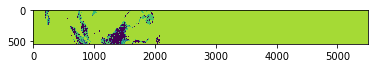

In [88]:
new_data = collocate_imagery(data, 5)

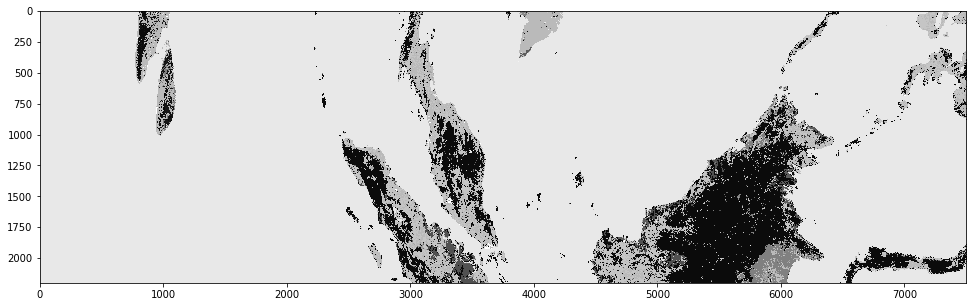

In [89]:
plt.figure(figsize=(18,5))
plt.imshow(new_data['lcov'][:, 0:7500], cmap='gray', vmin=0)
plt.show()

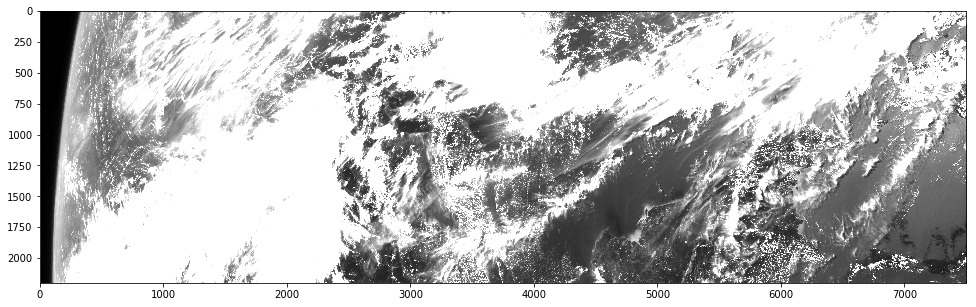

In [90]:
plt.figure(figsize=(18,5))
plt.imshow(new_data['redrad'][:, 0:7500], cmap='gray', vmin=0, vmax=100)
plt.show()

In [104]:
cloud_free = new_data['vis'] < 0.05

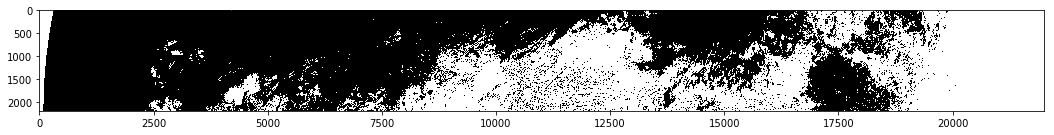

In [106]:
plt.figure(figsize=(18,5))
plt.imshow(cloud_free, cmap='gray')
plt.show()

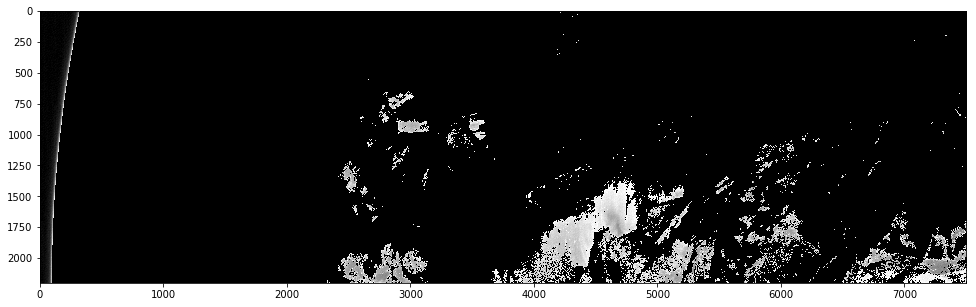

In [107]:
plt.figure(figsize=(18,5))
plt.imshow(cloud_free[:, 0:7500] * new_data['redrad'][:, 0:7500], cmap='gray', vmin=0)
plt.show()

In [87]:
def collocate_imagery(data, seg):
    new_data = data.copy()
    for k in new_data.keys():
        if new_data[k].shape[0] == 2200:
            continue
        elif new_data[k].shape[0] == 550:
            new_data[k] = ndimage.zoom(new_data[k], 4, order=0)
        elif new_data[k].shape[0] == 5500:
            y0 = (seg-1)*550
            y1 = y0+550
            subset = new_data[k][y0:y1,:]
            
            if k =='lcov':
                plt.imshow(subset)
                plt.show()
            new_data[k] = ndimage.zoom(subset, 4, order=0)
    return new_data
            
            

In [3]:
def load_h8(in_root, time_key, path_tree=None, mode=0):
    """
    load all the data and put them in a dictionary
    """
    # firstly setup the path dictionary
    EO_path_dict = load_hrit.paths(in_root, time_key=time_key, path_tree=path_tree, mode=0)

    # readin all the Himawari files here
    EO_data = load_hrit.Himawari_read(EO_path_dict)
    # construt a static data dictionary
    static_path_dict = load_hrit.paths(in_root)
    # readin all static data here
    static_data = load_hrit.static_read(static_path_dict)
    
    szen, saa = load_hrit.sun_angles(static_data['lat'], static_data['lon'], time_key)
    # get the sun glint angle
    sun_glint = load_hrit.sunglint(static_data['vza'], static_data['vaa'], szen, saa)
    
    # combine EO and static data together
    EO_data.update(static_data)
    EO_data['szen'] = szen
    EO_data['sun_glint'] = sun_glint
    EO_data['ACQTIME'] = np.zeros(EO_data['ir39'].shape, dtype=np.int8)
    
    return EO_data
